# 1) Importing Libraries

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
#sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess for Agumentaion.
from keras.preprocessing.image import ImageDataGenerator

#DL libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop, Nadam
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  



In [2]:
import os
# os.listdir('Final_Arabic_Alpha_dataset/train/')

# 2) Training dataset preparation

### 2.1) Get the training dataset

In [3]:
DIR = '/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/train'
X = []
Z = []
Label_names = []
IMG_SIZE = 64
dictionary_of_labels = {}

In [4]:
def make_train_data():
    for label in tqdm(os.listdir(DIR)):
        if label == '.DS_Store' :
            continue
        label_path = os.path.join(DIR, label)
        for image_name in os.listdir(label_path): 
            image_path = os.path.join(label_path, image_name)
            result_label = image_name[8:-8]
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)
            if img is None:
                print('Wrong path:', img)
            else:
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                X.append(np.array(img))
                Z.append(int(label))
        dictionary_of_labels[int(label)] = str(result_label)

In [5]:
make_train_data()

100%|██████████| 65/65 [05:06<00:00,  4.72s/it]


In [6]:
print(len(Z))
#42559

42559


### 2.3) Visualizing some Random Images

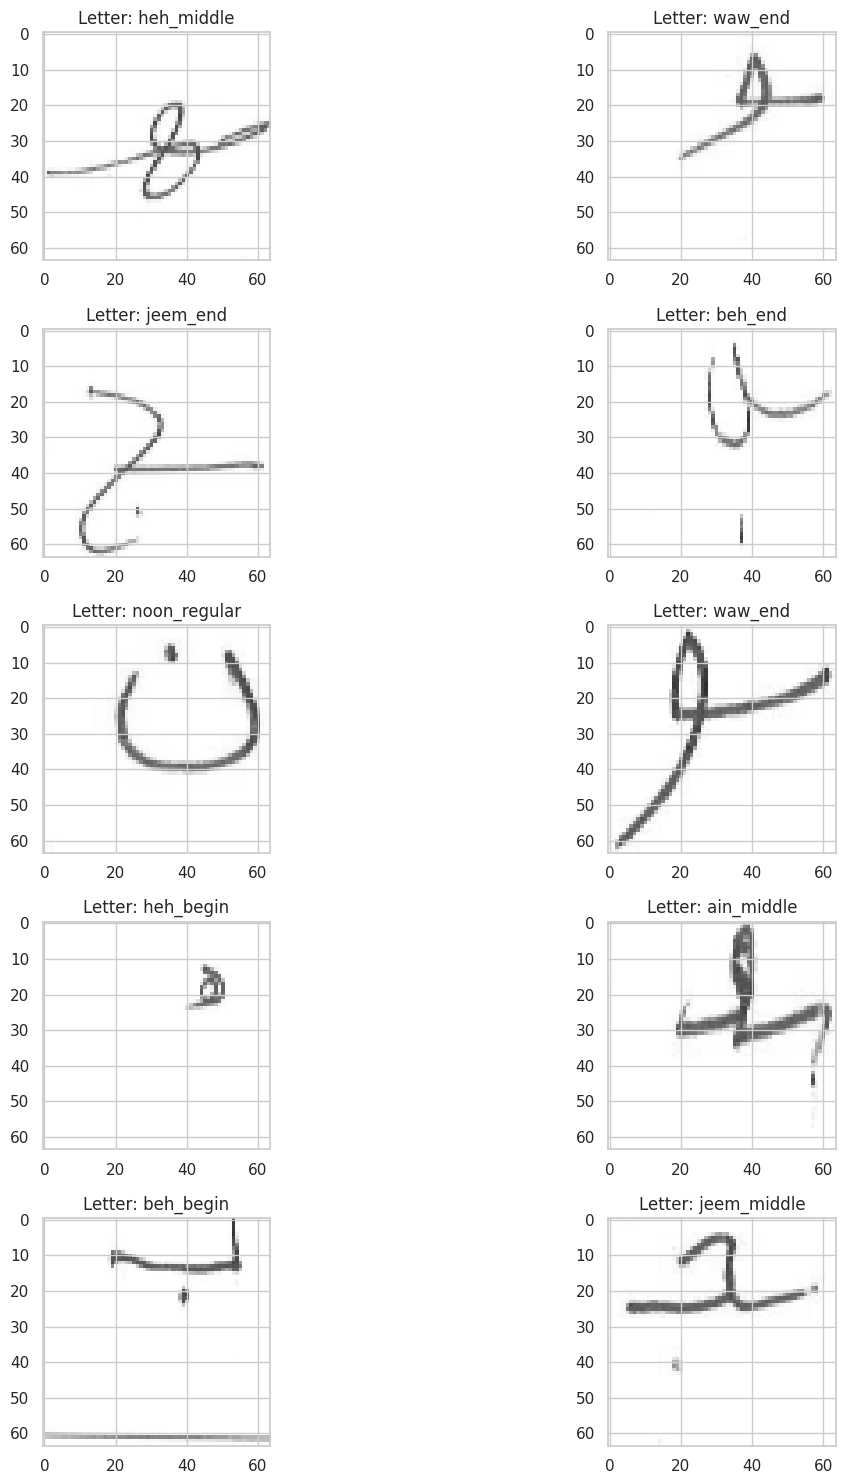

In [7]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Letter: '+ dictionary_of_labels[Z[l]])
        
plt.tight_layout()

### 2.4 ) Label Encoding the Z array (0 - 64)

In [8]:
le=LabelEncoder()
Y=le.fit_transform(Z)
X=np.array(X)
# X=X/255

In [9]:
Z = np.array(Z) 

### 2.5) Splitting into Training and Validation Sets

In [10]:
x_train,x_test,y_train,y_test=train_test_split(X,Z,test_size=0.25,random_state=42)

### 2.6) Setting the Random Seeds

In [11]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

# 3) Modeling

### 3.1) Building the ConvNet Model

In [12]:
# modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(65, activation = "softmax"))

### 3.2 ) Using a LR Annealer

In [13]:
batch_size=128
epochs=50

# from keras.callbacks import ReduceLROnPlateau
# red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=5,verbose=1,factor=0.1)

### 3.3 ) Data Augmentation to prevent Overfitting

In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

### 3.4 ) Compiling the Keras Model & Summary

In [15]:
model.compile(optimizer=Adam(lr=0.01),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# model.compile(optimizer = SGD(lr=0.1) ,loss='sparse_categorical_crossentropy', metrics=['accuracy']) 


# model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=Adagrad(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=Nadam(lr=0.002), loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 96)          0

In [17]:
# y_train = np.expand_dims(y_train, axis=-1)
# y_test = np.expand_dims(y_test, axis=-1)
# x_test = np.expand_dims(x_test, axis=-1)

In [18]:
# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)

In [19]:
# History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              #epochs = epochs, validation_data = (x_test,y_test),
                            #  verbose = 1, steps_per_epoch=250)
History = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50
250/250 [==============================] - 162s 644ms/step - loss: 4.1606 - accuracy: 0.1850 - val_loss: 1.8723 - val_accuracy: 0.4600
Epoch 2/50
250/250 [==============================] - 159s 637ms/step - loss: 1.3312 - accuracy: 0.6086 - val_loss: 1.1974 - val_accuracy: 0.6600
Epoch 3/50
250/250 [==============================] - 160s 638ms/step - loss: 0.7575 - accuracy: 0.7638 - val_loss: 0.8710 - val_accuracy: 0.7445
Epoch 4/50
250/250 [==============================] - 160s 642ms/step - loss: 0.5242 - accuracy: 0.8316 - val_loss: 0.7231 - val_accuracy: 0.7877
Epoch 5/50
250/250 [==============================] - 159s 637ms/step - loss: 0.3969 - accuracy: 0.8689 - val_loss: 0.7973 - val_accuracy: 0.7836
Epoch 6/50
250/250 [==============================] - 158s 633ms/step - loss: 0.3026 - accuracy: 0.8982 - val_loss: 0.7344 - val_accuracy: 0.8078
Epoch 7/50
250/250 [==============================] - 156s 623ms/step - loss: 0.2377 - accuracy: 0.9197 - val_loss: 0.7199 -

# 4 ) Evaluating the Model Performance

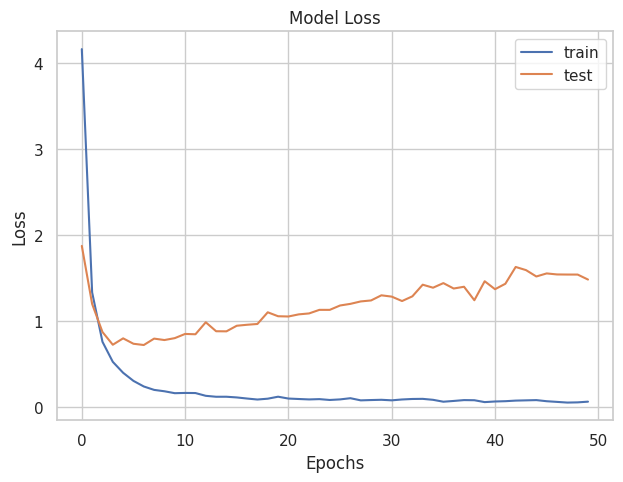

In [20]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

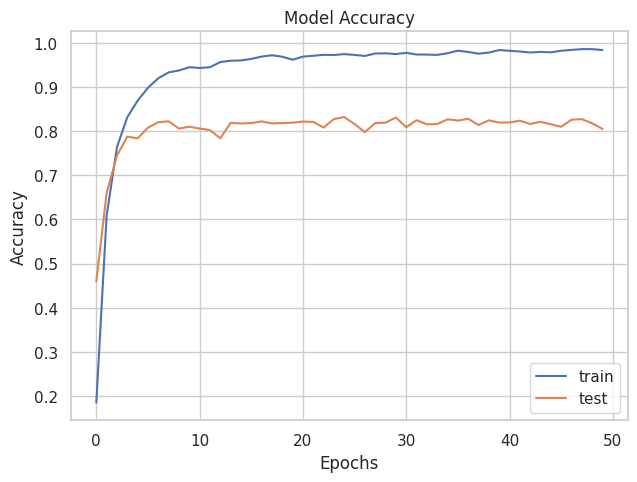

In [21]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# 5 ) Visualizing Predictons on the Validation Set

In [22]:
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

333/333 [==============================] - 14s 41ms/step


### 5.1) Get a list of correct and incorrect predictions

In [23]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(y_test[i]==pred_digits[i]):
        prop_class.append(i)
#     if(len(prop_class)==8):
#         break

i=0
for i in range(len(y_test)):
    if(y_test[i] != pred_digits[i]):
        mis_class.append(i)
#     if(len(mis_class) == 8):
#         break

In [24]:
print(f"Number of correct predictions: {len(prop_class)}")
print(f"Number of incorrect predictions: {len(mis_class)}")
print(f"Accuracy: {len(prop_class)/(len(prop_class) + len(mis_class) ) } ")

Number of correct predictions: 8566
Number of incorrect predictions: 2074
Accuracy: 0.8050751879699248 


### 5.2) Visualizing two smaples of correct and incorrect predictions

#### Correct

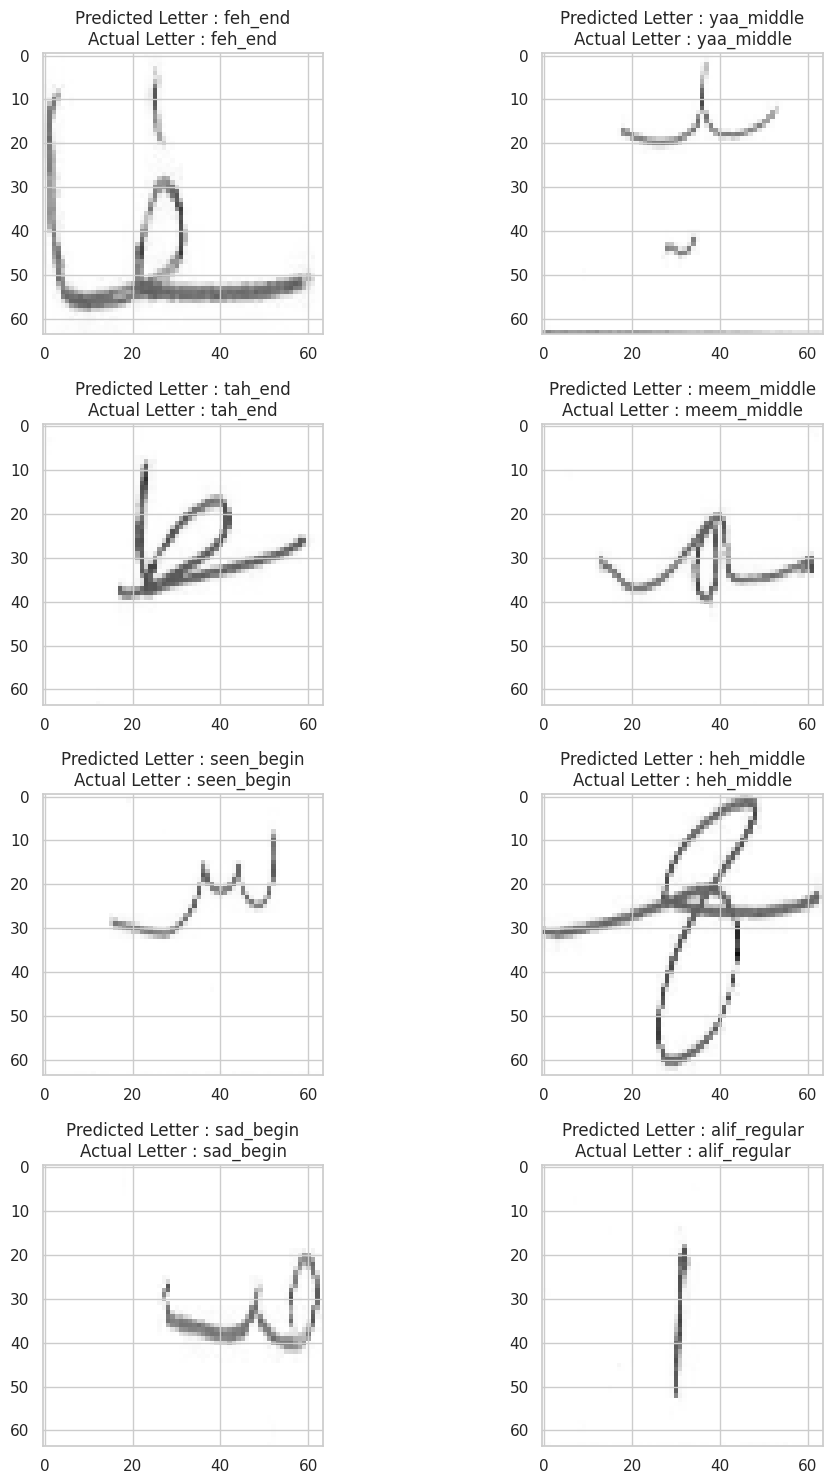

In [25]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Letter : " + str(dictionary_of_labels[pred_digits[prop_class[count]]])+
                          "\n" + "Actual Letter : " + str( dictionary_of_labels[y_test[prop_class[count]]]))

        plt.tight_layout()
        count+=1

#### Incorrect

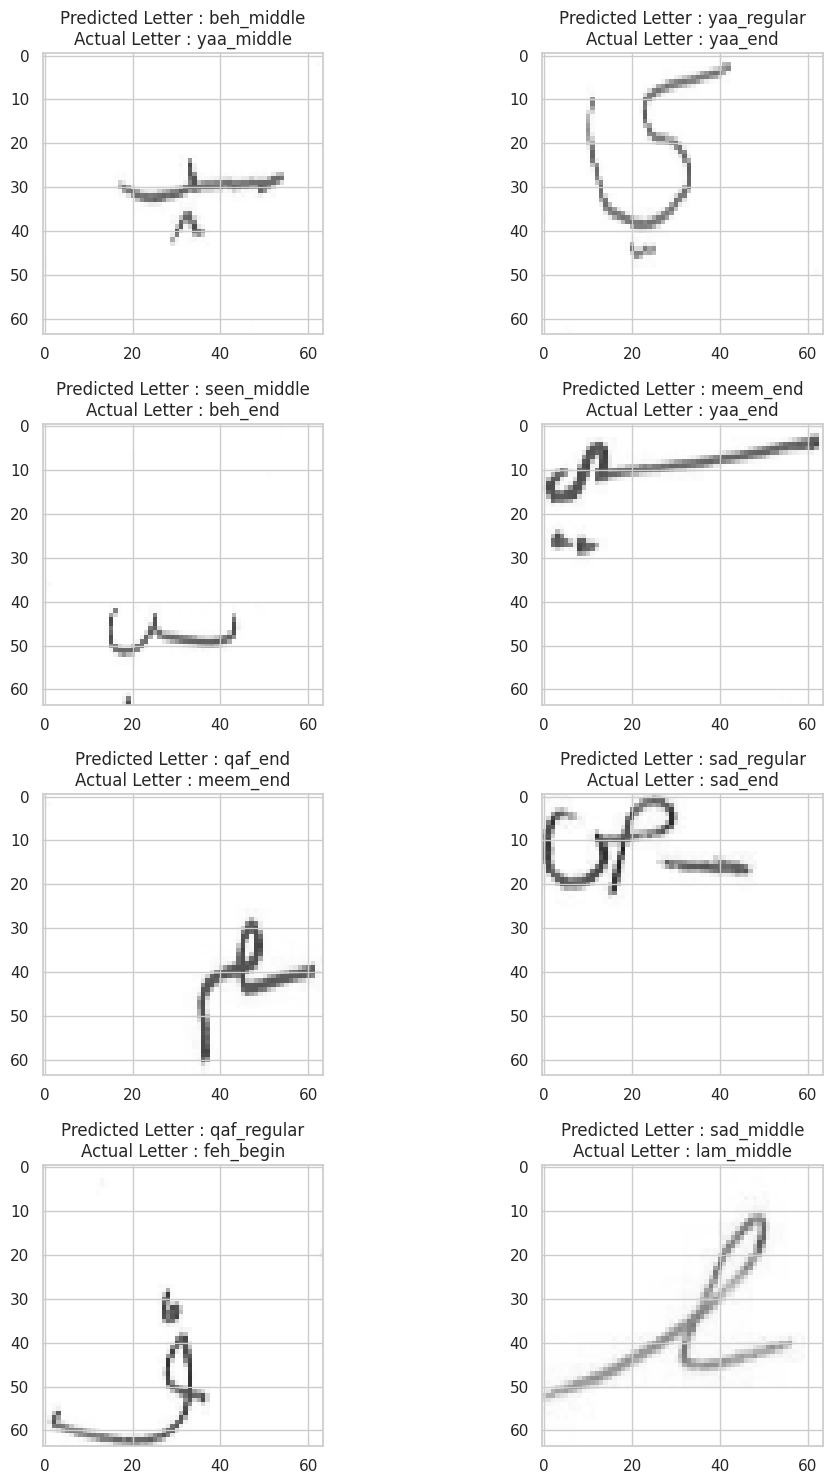

In [26]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Letter : " + str( dictionary_of_labels[pred_digits[mis_class[count]]])+
                          "\n" + "Actual Letter : " + str( dictionary_of_labels[y_test[mis_class[count]]]))

        plt.tight_layout()
        count+=1

# 6) Perediction of Test Images

### 6.1) Get the test images

In [27]:
DIR_Test = '/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/test'
X_test = []
image_names = []

In [28]:
def make_test_data():
        for image_name in tqdm(os.listdir(DIR_Test)): 
            image_path = os.path.join(DIR_Test, image_name)
            image_names.append(image_name)
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)
            if img is None:
                print('Wrong path:', img)
            else:
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                X_test.append(np.array(img))

In [29]:
make_test_data()

100%|██████████| 10640/10640 [01:39<00:00, 106.69it/s]


In [30]:
X_test=np.array(X_test)

### 6.2) Make predictions of test images

In [31]:
pred_test=model.predict(X_test)

333/333 [==============================] - 13s 40ms/step


In [32]:
pred_digits_test=np.argmax(pred_test,axis=1)

### 6.3) Visualisations of some random predicted images

100%|██████████| 8/8 [00:21<00:00,  2.68s/it]


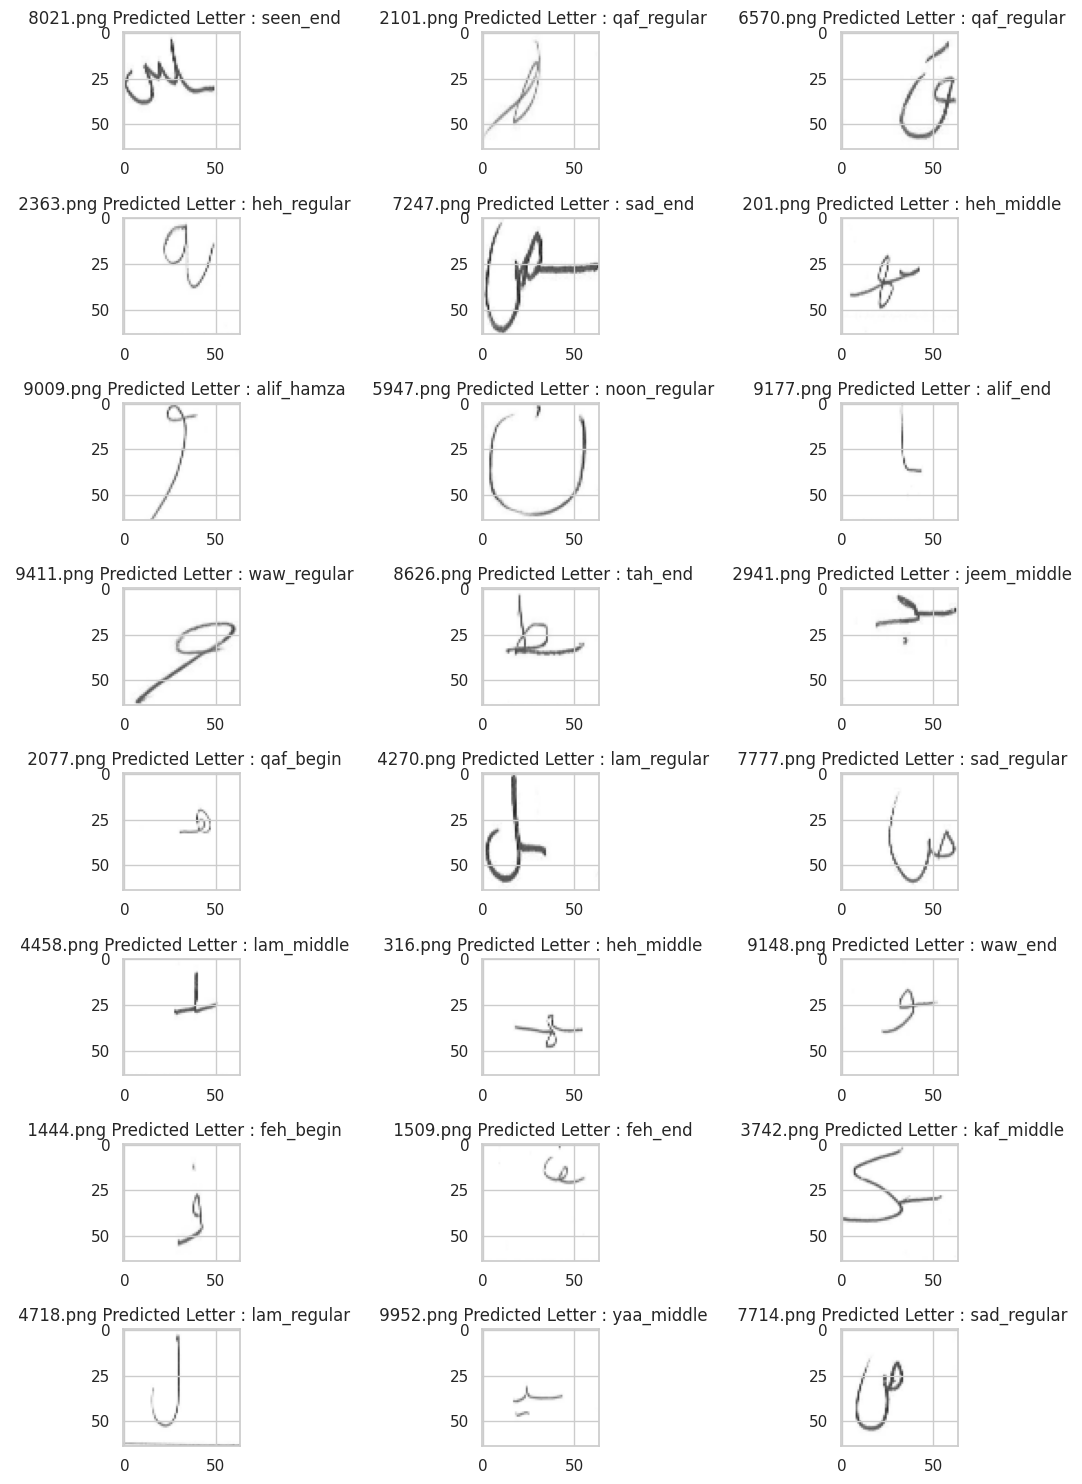

In [33]:
fig,ax=plt.subplots(8,3)
fig.set_size_inches(15,15)
for i in tqdm(range (8)):
    for j in range (3):
        image_number=rn.randint(0,len(X_test))
        ax[i,j].imshow(X_test[image_number])
        ax[i,j].set_title(f" {image_names[image_number]} Predicted Letter : " +
                          str(dictionary_of_labels[pred_digits_test[image_number]]))
        plt.tight_layout()

### 6.3) exporting the predicted

In [34]:
predictions = pred_digits_test
predictions_label = [dictionary_of_labels[i] for i in pred_digits_test]
image_numbers = [int(s[:-4]) for s in image_names]

In [35]:
df = pd.DataFrame({'ID': image_numbers, 'Label': predictions})

In [36]:
df = df.sort_values(by='ID')

In [37]:
df.to_csv('/kaggle/working/predictions5.csv', index=False)